# Get started with circuit cutting using wire cuts

This guide demonstrates a working example of wire cuts with the `qiskit-addon-cutting` package. It covers reconstructing expectation values of a seven-qubit circuit using wire cutting.

A wire cut is represented in this package as a two-qubit [`Move`](/api/qiskit-addon-cutting/instructions-move) instruction, which is defined as a reset of the second qubit the instruction acts on, followed by a swap of both qubits. This operation is equivalent to transferring the state of the first qubit to the second qubit, while simultaneously discarding the incoming state of the second qubit.

The package is designed to be consistent with the way you must treat wire cuts when acting on physical qubits. For example, a wire cut might take the state of physical qubit $n$ and continue it as a physical qubit $m$ after the cut. You can think of "instruction cutting" as a unified framework for considering both wire and gate cuts within the same formalism (since a wire cut is just a cut [`Move`](/api/qiskit-addon-cutting/instructions-move) instruction). Using this framework for wire cutting also allows for qubit re-use, which is explained in the section on [cutting wires manually](#cut-wires-using-the-low-level-move-instruction).

The single-qubit [`CutWire`](/api/qiskit-addon-cutting/instructions-cut-wire) instruction acts as a more abstracted, simpler interface for working with wire cuts. It allows you to denote where in the circuit a wire should be cut at a high level and have the circuit cutting addon insert the appropriate [`Move`](/api/qiskit-addon-cutting/instructions-move) instructions for you.

The following example demonstrates expectation value reconstruction after wire cutting. You will create a circuit with several non-local gates and define observables to estimate.

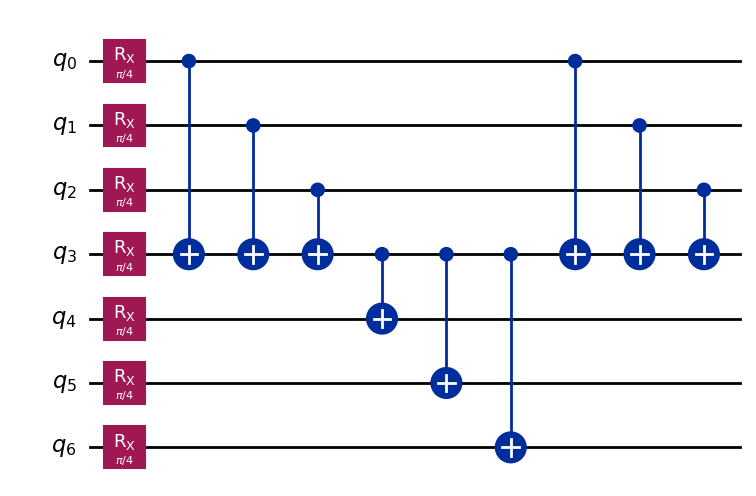

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2

from qiskit_addon_cutting.instructions import Move, CutWire
from qiskit_addon_cutting import (
    partition_problem,
    generate_cutting_experiments,
    cut_wires,
    expand_observables,
    reconstruct_expectation_values,
)


qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

# Define observable
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

# Draw circuit
qc_0.draw("mpl")

## Cut wires using the high-level `CutWire` instruction

Next, make wire cuts using the single-qubit [`CutWire`](/api/qiskit-addon-cutting/instructions-cut-wire) instruction on qubit $q_3$. Once the subexperiments are prepared to be executed, use the [`cut_wires()`](/api/qiskit-addon-cutting/qiskit-addon-cutting#cut_wires) function to transform `CutWire` to [`Move`](/api/qiskit-addon-cutting/instructions-move) instructions on newly allocated qubits.

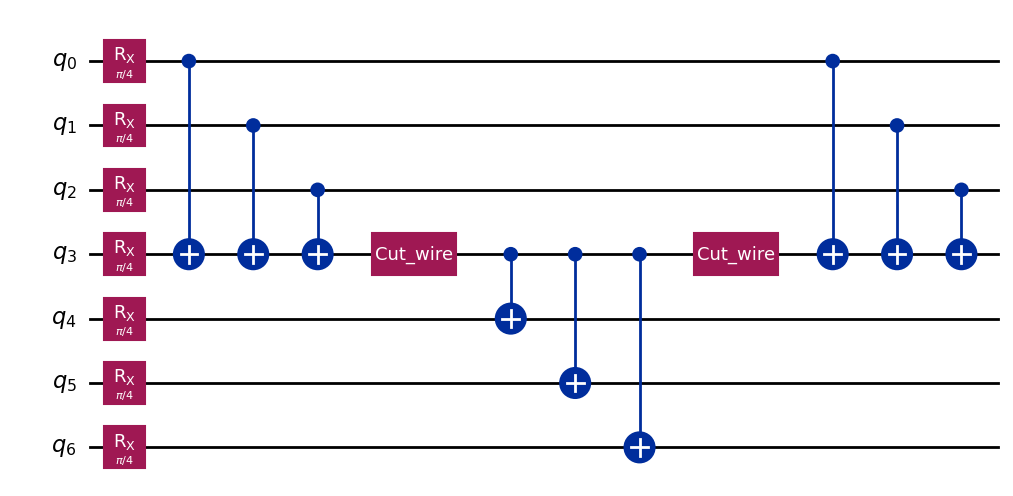

In [2]:
qc_1 = QuantumCircuit(7)
for i in range(7):
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(CutWire(), [3])
qc_1.cx(3, 4)
qc_1.cx(3, 5)
qc_1.cx(3, 6)
qc_1.append(CutWire(), [3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

qc_1.draw("mpl")

<Admonition type="info" title="Note about expanding observables">
    When a circuit is expanded through one or more wire cuts, the observable needs to be updated to account for the extra qubits that are introduced. The `qiskit-addon-cutting` package has a convenience function [`expand_observables()`](/api/qiskit-addon-cutting/qiskit-addon-cutting#expand_observables), which takes `PauliList`s and the original and expanded circuits as arguments, and returns a new `PauliList`.

    This returned `PauliList` will not contain any information about the original observable's coefficients, but these can be ignored until reconstruction of the final expectation value.
</Admonition>

Expanded Observable: ['ZIIIIIIII', 'IIIZIIIII', 'IIIIIIIIZ']


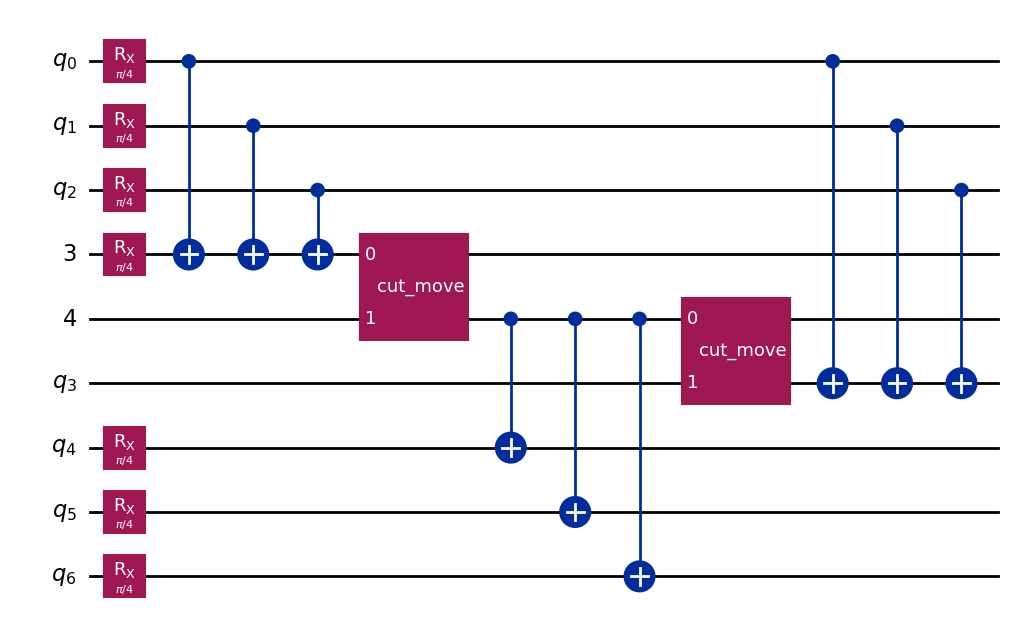

In [3]:
# Transform CutWire instructions to Move instructions
qc_2 = cut_wires(qc_1)

# Expand the observable to match the new circuit size
expanded_observable = expand_observables(observable.paulis, qc_0, qc_2)
print(f"Expanded Observable: {expanded_observable}")
qc_2.draw("mpl")

### Partition the circuit and observable

Now the problem can be separated into partitions. This is accomplished using the [`partition_problem()`](/api/qiskit-addon-cutting/qiskit-addon-cutting#partition_problem) function with an optional set of partition labels to specify how to separate the circuit. Qubits sharing a common partition label are grouped together, and any non-local gates spanning more than one partition are cut.

If no partition labels are provided, then the partitioning will be automatically determined based on the connectivity of the circuit. Read the next section on [cutting wires manually](#cut-wires-using-the-low-level-move-instruction) for more information on including partition labels.

Subobservables to measure: 
{0: PauliList(['IIIII', 'ZIIII', 'IIIIZ']), 1: PauliList(['ZIII', 'IIII', 'IIII'])}

Sampling overhead: 256.0


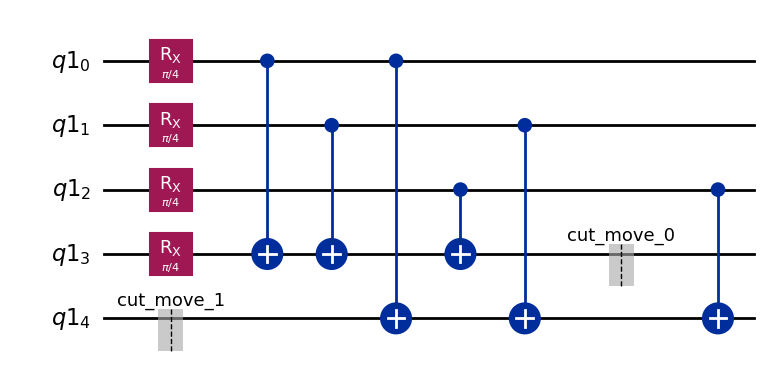

In [4]:
partitioned_problem = partition_problem(
    circuit=qc_2,
    observables=expanded_observable,
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

print(f"Subobservables to measure: \n{subobservables}\n")
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
subcircuits[0].draw("mpl")

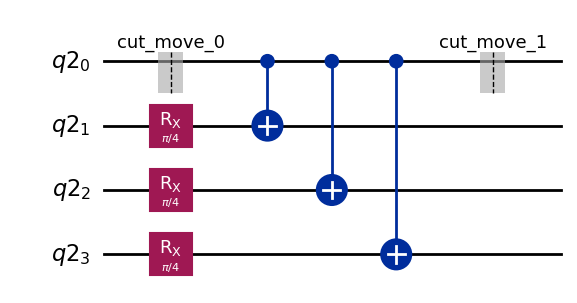

In [5]:
subcircuits[1].draw("mpl")

In this partitioning scheme, you have cut two wires, resulting in a sampling overhead of $4^4$.

### Generate subexperiments to execute and post-process results

To estimate the expectation value of the full-sized circuit, several subexperiments are generated from the decomposed gates' joint quasi-probability distribution and then executed on one (or more) QPUs. The [`generate_cutting_experiments`](/api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments) method does this by ingesting arguments for the `subcircuits` and `subobservables` dictionaries you created above, as well as for the number of samples to take from the distribution.

<Admonition type="note" title="Note about the number of samples">
    The `num_samples` argument specifies how many samples to draw from the quasi-probability distribution and determines the accuracy of the coefficients used for the reconstruction. Passing infinity (`np.inf`) ensures all coefficients are calculated exactly. Read the API docs on [generating weights](/api/qiskit-addon-cutting/qpd#generate_qpd_weights) and [generating cutting experiments](/api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments) for more information.
</Admonition>

In [6]:
# Generate subexperiments
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
    # Retrieve results
    results = {label: job.result() for label, job in jobs.items()}

Lastly, the expectation value of the full circuit can be reconstructed using the [`reconstruct_expectation_values()`](/api/qiskit-addon-cutting/qiskit-addon-cutting#reconstruct_expectation_values) method.


The code block below reconstructs the results and compares them with the exact expectation value.

In [7]:
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
# Apply the coefficients of the original observable
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)


# Compute the exact expectation value using the `qiskit_aer` package.
estimator = EstimatorV2()
exact_expval = estimator.run([(qc_0, observable)]).result()[0].data.evs
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 1.55984855
Exact expectation value: 1.59099026
Error in estimation: -0.03114171
Relative error in estimation: -0.01957379


<Admonition type="caution" title="Note about observable coefficients">
    To accurately reconstruct the expectation value, the coefficients of the original observable (which are different from the output of `generate_cutting_experiments()`) must be applied to the output of the reconstruction, since this information was lost when the cutting experiments were generated or when the observable was expanded.

    Typically these coefficients can be applied through `numpy.dot()` as shown previously.
</Admonition>

## Cut wires using the low-level `Move` instruction

One limitation of using the higher-level `CutWire` instruction is that it does not allow for qubit re-use. If this is desired for a cutting experiment, you can instead manually place [`Move`](/api/qiskit-addon-cutting/instructions-move) instructions. However, because the `Move` instruction discards the state of the destination qubit, it is important that this qubit does not share any entanglement with the remainder of the system. Otherwise, the reset operation will cause the state of the circuit to partially collapse after the wire cut.

The code block below performs a wire cut on qubit $q_3$ for the same example circuit as previously shown. The difference here is that you can reuse a qubit by reversing the `Move` operation where the second wire cut was made (however, this is not always possible and depends on the circuit being cut).

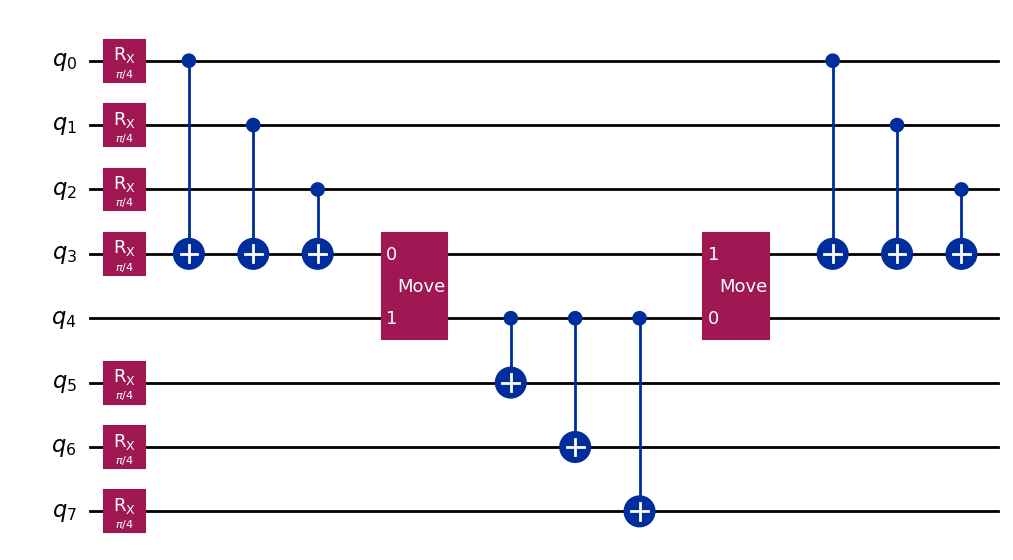

In [8]:
qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

# Expand observable
observable_expanded = SparsePauliOp(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])
qc_1.draw("mpl")

The circuit above can now be partitioned and cutting experiments generated. To explicitly specify how the circuit should be partitioned, you can add partition labels to the `partition_problem()` function. Qubits that share a common partition label are grouped together, and any non-local gates spanning more than one partition are cut. The keys of the dictionary output by `partition_problem()` will match those specified in the label string.

Subobservables to measure: 
{'A': PauliList(['IIII', 'ZIII', 'IIIZ']), 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

Sampling overhead: 256.0


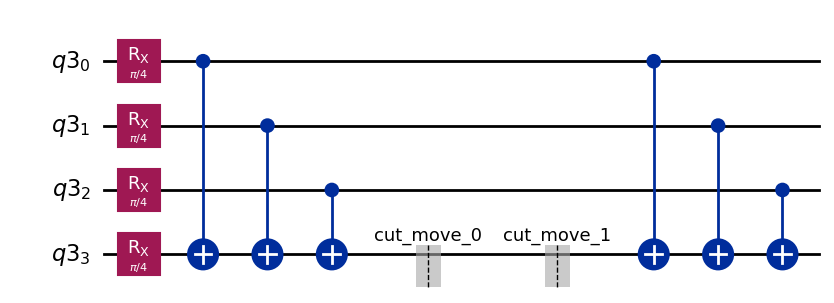

In [9]:
partitioned_problem = partition_problem(
    circuit=qc_1,
    partition_labels="AAAABBBB",
    observables=observable_expanded.paulis,
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

print(f"Subobservables to measure: \n{subobservables}\n")
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
subcircuits["A"].draw("mpl")

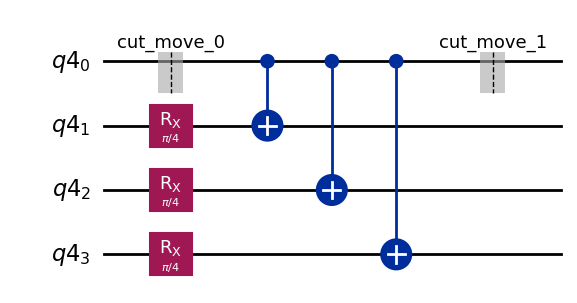

In [10]:
subcircuits["B"].draw("mpl")

Now the cutting experiments can be generated and the expectation value reconstructed in the same way as the previous section.

## Next steps

<Admonition type="tip" title="Recommendations">
    - Read the [Get started with circuit cutting using gate cuts](/guides/qiskit-addons-cutting-gates) guide.
    - Read the arXiv paper on [optimal wire cutting](https://arxiv.org/abs/2302.03366) to better understand the equivalence between wire cutting and gate cutting.
</Admonition>